## Lesson 5
### Robert Lisy

Identify a likely distribution for price and several other features. For example, you should determine if the price is better represented by the log of price.
- Compute basic summary statistic of the mean by both classical bootstrap and Bayesian methods
- Compute confidence intervals for the summary statistics by classical bootstrap and Bayesian methods
- Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are statistically significant. You will continue the analysis that you started in Assignment 04. For each of the groupings you analyzed in Assignment 04, apply the following methods:
    - Bootstrap methods
    - Bayesian model

Compare the results from step 4 above with those you found in Assignment 04 with classical t-tests, Tukey HSD, and ANOVA.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import statsmodels.stats as st
import statsmodels.api as sm
import statsmodels.stats.api as sms

pd.options.mode.chained_assignment = None

df = pd.read_csv('Automobile price data _Raw_.csv')
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [2]:
# throw out non numeric prices
df = df[df['price'].apply(lambda x: x.isnumeric())]
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


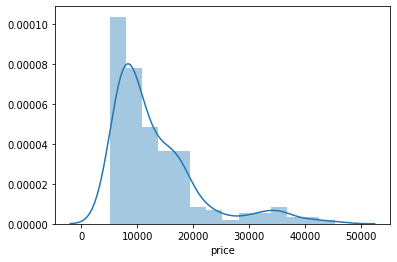

In [3]:
# plot the price to find a good distribution
sns.distplot(df['price']);

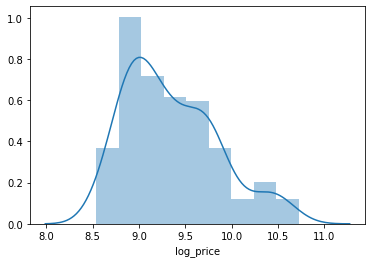

In [4]:
# that looks log normal...
df['log_price'] = np.log(df['price'])

# much nicer.
sns.distplot(df['log_price']);

In [12]:
# set the number of samples we'll use for bootstrapping.
n_samples = 1000

In [13]:
# Find the mean of the log price via bootstrapping

# add in a nice plotting function with mean line
def plot_dist_mean(a, a_label):
    sns.distplot(a, label=a_label)
    plt.axvline(x=a.mean(), ymin=0, ymax=1)

bootstrap_means = pd.Series([    
    df.sample(frac=1, replace=True)['log_price'].mean()
    for i in range(n_samples)])

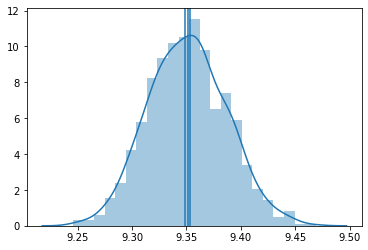

In [17]:
# From the bootstrapped samples, also show the 95% CI
ci_5, ci_95 = sms.DescrStatsW(bootstrap_means).tconfint_mean()

plot_dist_mean(bootstrap_means, 'Bootstrapped Mean with 5 and 95% CI');
plt.axvline(x=ci_5, ymin=0, ymax=1)
plt.axvline(x=ci_95, ymin=0, ymax=1)

# Bayesian Approach

In [18]:
# Generate a prior distribution that's uniform between the min and max of the price
N = 1000
x = np.linspace(start=df['log_price'].min(), stop=df['log_price'].max(), num = N)

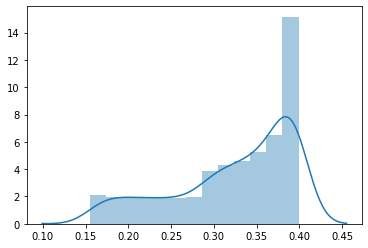

In [24]:
# now make the PDF
prior_price = scipy.stats.norm.pdf(x, loc = df['log_price'].mean(), scale = 1)

# plot the prior's PDF
sns.distplot(prior_price);

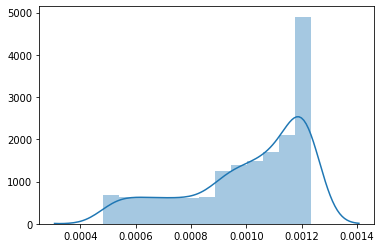

In [23]:
# Normalize and plot the PDF
prior_price = prior_price / prior_price.sum()
sns.distplot(prior_price);

In [37]:
price_sample = df.sample(n=n_samples, replace=True)

Bayesian mean = 9.335, standard deviation = 0.497


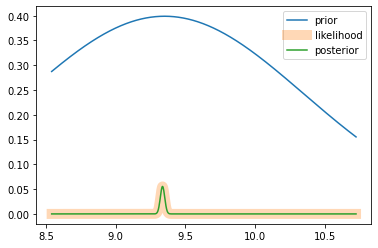

In [38]:
def likelihood(p, x): 
    x_var = np.var(x) # sigmasqr
    x_mean = np.mean(x)  # xbar
    print('Bayesian mean = %.3f, standard deviation = %.3f' % (x_mean, x_var**0.5))
    n = len(x)
    l = np.exp((-1/(2*x_var)) * (sum((x - x_mean)**2) + n*(x_mean - p)**2))
    return l / l.sum()

def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / post.sum() # normalize the distribution to sum to unity

likelihood_price = likelihood(x, price_sample['log_price'])
posterior_price = posterior(prior_price, likelihood_price)

sns.lineplot(x, prior_price, label = 'prior')
sns.lineplot(x, likelihood_price, label = 'likelihood', alpha = .3, linewidth = 10)
sns.lineplot(x, posterior_price, label = 'posterior')
plt.legend();

The 0.950 credible interval is 0.025 to 0.975


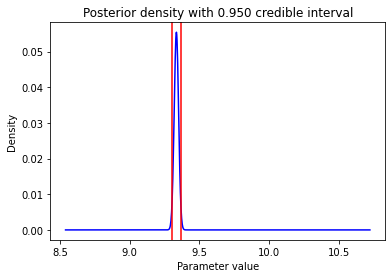

In [39]:
# let's plot the credible interval for the mean estimate
lower_q, upper_q = [.025, .975]
def plot_ci(p, post, num_samples, lower_q, upper_q, **kw):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size = num_samples, replace = True, p = post)
    ci = np.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    sns.lineplot(p, post, color = 'blue', **kw)
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x = ci[0], color = 'red')
    plt.axvline(x = ci[1], color = 'red')
    print('The {:0.3f} credible interval is {:0.3f} to {:0.3f}'.format(interval, lower_q, upper_q))
    
plot_ci(x, posterior_price, N, lower_q, upper_q)

# Wrapup

Honestly, I don't really understand this homework that well. Dock me points if you have to, that's fine.

I get that at any point we're trying to find a distribution, and I believe that the price for the automotive data set is log normal distributed. I get that sampling the distribution many many times via bootstrapping should get us closer to the "real population" mean. I also understand that the Bayesian approach uses a prior, then updates that with information from the data. That's about all I have though. I don't really get how to do hypothesis testing using these approaches, but it would probably look like this:

##### Bootstrapping
- sample the data a bunch of times between the categories
- generate a mean, plus 95% CI for the series, broken down by each category
- see if those means overlap the 95% CI for other series

If they do, then the series may share the same mean. If they don't, then they're probaby different

##### Bayesian
- create a prior (probably uninformed)
- sample data through the Bayesian approach many many times, for each category
- create the posterior distribution (one for each category)
- generate sample data from the posterior distribution and see if the CI overlaps
